<img src="imgs/xaida_logo.png" width=100 height=100 />

# **Artificial Intelligence for Disentangling Extremes (AIDE) Toolbox**
## **Tutorial: Drought Detection using DroughtED Database and Outlier Detection Algorithms**
### September 2023

###  This notebook aims to provide users with practical experience in utilising the toolbox...... 

>    <span style="font-size: 16px; color: red;" > To gain a comprehensive understanding of the toolbox's structure and detailed usage instructions, we highly recommend referring to the user guide available in the "Read the Docs" reference. Familiarising yourself with the user guide will ensure you have a solid foundation to make the most out of the tutorial and leverage the toolbox effectively.

---
## Tutorial workflow
---

    1. PREREQUISITES OF THE TOOLBOX

    2. USER'S SET-UP

  >  2.1 DATASET 
  
  >  2.2 CHOOSING A MODEL
  
  >  2.2 CONFIGURATION FILE
    
    3. TRAINING

    4. EVALUATION AND VISUALIZATION

---
## 1. Prerequisites of the toolbox
---

Please, start running the following cells to check out the contents of the toolbox, install its dependencies and import the required libraries to make use of it.

#### a) Check out the contents of the AIDE toolbox

In [1]:
# Uncomment to run the notebook in Google Colab
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
# %cd /content/drive/MyDrive/AIDE/AIDE/notebooks

In [3]:
a = %pwd

if a.split("/")[-1] != "AIDE":
    %cd ../
%ls -h

/home/miguelangelft/Documents/research/xaida/AIDE_private/AIDE
backbones/  databases/   experiments/  tutorials/     utils/
configs/    evaluators/  main.py*      user_defined/


#### b) Install dependencies

In [4]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt

#### c)  Import required libraries

In [5]:
# GENERAL
import os, sys
from os.path import dirname, abspath

# NUMPY
import numpy as np

# PANDAS
import pandas as pd

# XARRAY
import xarray as xr

# ITERTOOLS
import itertools

# TIME, DATETIME
import time
from datetime import datetime

# SCIPY
from scipy.interpolate import interp1d

# SKLEARN
from sklearn.preprocessing import RobustScaler

# DATASET CLASSES
from databases import *

# MODEL TEMPLATE CLASS
from  backbones import *

# EVALUATION
from evaluators import *

# METRICS
from utils.misc import * 
from utils.setup_config import setup

import yaml
from os.path import dirname, abspath
from pathlib import Path
import sys

# MATPLOTLIB
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
pd.set_option('display.max_rows', 50)

In [6]:
# Add current path into Python path
current_d = dirname(abspath("__file__"))
sys.path.insert(0, current_d)

---
## 2. User-defined set-up
---

### 2.1 DATABASE

#### 2.1.1 DroughtED

The DroughtED classification database [Minixhofer, C] consists of globally available meteorological features paired with location meta-data. It can be downloaded by using [this link](https://www.kaggle.com/datasets/cdminix/us-drought-meteorological-data/download). 

- Data dimensionality:

Each entry is a daily drought level at a specific point in time in a specific US county, accompanied by 18 meteorological indicators.

- Drought levels:

DroughtED is a classification dataset with six levels of drought, depicted in the following image:

![](https://drive.google.com/uc?export=view&id=1DV-BjfcTV5e8iSSuQS93Hrt3mrRsakot)


To work with the Outlier Detection algorithms, we binarize the categorization to obtain our anomalous and non-anomalous classes:

![](https://drive.google.com/uc?export=view&id=1nGUn_VOttbepgMaG_t5Ccdhe32qP0jNr)

- Meteorological indicators:

The DroughtED database contains 18 meteorological indicators. 

 ||||
 |---|---|---|
 |- Minimum Wind Speed at 10 Meters (m/s) | - Specific Humidity at 2 Meters (g/kg) | - Temperature Range at 2 Meters (C)|
 |- Wind Speed at 10 Meters (m/s)|- Temperature at 2 Meters (C)|- Minimum Wind Speed at 50 Meters (m/s)|
 |- Maximum Temperature at 2 Meters (C)|- Wind Speed at 50 Meters (m/s)|- Earth Skin Temperature (C)|
 |- Wind Speed Range at 50 Meters (m/s)|- Maximum Wind Speed at 50 Meters (m/s)|- Maximum Wind Speed at 10 Meters (m/s)|
 |- Wind Speed Range at 10 Meters (m/s)|- Surface Pressure (kPa)|- Dew/Frost Point at 2 Meters (C)|
 |- Minimum Temperature at 2 Meters (C)|- Wet Bulb Temperature at 2 Meters (C)|- Precipitation (mm day-1)|

- Data subsets:

This dataset contains data from 2000 up until 2020. For simplicity, in this tutorial we define the data subsets as follows: 

| Split |  Year Range (inclusive) |
|---|---|
| Train | 2018|
| Validation  | 2019  |
| Test  | 2020  |


In [7]:
files = {}

for dirname, _, filenames in os.walk('databases/DroughtED/'):
    for filename in filenames:
        if 'valid' in filename:
            files['valid'] = os.path.join(dirname, filename)
dfs = {
    k: pd.read_csv(files[k]).set_index(['fips', 'date'])
    for k in files.keys()
}
print(dfs['valid'])

                  PRECTOT      PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  \
fips  date                                                                 
1001  2017-01-01    32.50  100.02  10.47  14.69   14.47   14.47    17.68   
      2017-01-02    63.52  100.04  12.75  17.96   17.75   17.75    20.30   
      2017-01-03    18.82   99.69   9.74  14.24   13.44   13.44    18.48   
      2017-01-04     0.01  100.02   5.21   8.10    3.86    3.88    11.74   
      2017-01-05     0.01   99.89   4.54   5.91    2.20    2.22    13.07   
...                   ...     ...    ...    ...     ...     ...      ...   
56043 2018-12-27     0.14   82.71   1.54  -9.57  -14.20  -13.09    -6.23   
      2018-12-28     0.02   83.14   1.32 -11.25  -15.98  -14.57    -7.03   
      2018-12-29     0.34   82.78   1.75  -7.17  -12.62  -12.17     0.64   
      2018-12-30     3.17   81.97   2.72  -2.84   -7.14   -6.95     2.14   
      2018-12-31     1.39   83.16   1.03 -13.02  -18.93  -16.97    -9.70   

           

#### 2.1.2 The dataset file

For the users to be able to work with their own dataset, they have to create a dataset file NAME_database.py (DroughtED_database.py in this example) which will define a class NAME (DroughtED in this example). This class DroughtED will read, split the data and perform any preprocessing needed.

Unsupervised outlier detection algorithms available in the Python Outlier Detection (PyOD) library used as backend work with the whole set of data at the same time, so the function required in the DroughtED_database.py for this group of algorithms has to have the following structure:

![](https://drive.google.com/uc?export=view&id=17nlpNcz5KkzAaJ10tEx9UHvbZ5BEdgK8)

Without going into detail about the whole script, in the following image you can see a snippet of how it should be: 

![](https://drive.google.com/uc?export=view&id=19nsksFHqmwNpBoHrKll2BmkElkw6I9wR)

The function returns x and labels, which have the following dimensionality:

In [8]:
# Load the validation split for demonstration purposes
config = setup(current_d + "/configs/config_DroughtED_OutlierDetection.yaml")
data_val = eval('DroughtED')(config, period = 'val').__getallitems__()

  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 1100232 samples


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 1100232 samples


  0%|          | 0/2 [00:00<?, ?it/s]

[86.4291349460841, 13.5708650539159]


In [9]:
# Show the returned objects from __getallitems__
print(data_val)

{'x': array([[ 0.16694717,  0.16145487,  0.17047794, ...,  0.00443387,
         0.00355118, -0.00046997],
       [ 0.02916026,  0.01976876, -0.09439664, ..., -0.39198976,
        -0.35119544, -0.32302094]]), 'labels': array([0., 0., 0., ..., 0., 0., 0.])}


In [10]:
# Show one sample of data
print(data_val['x'].shape)

(2, 1100232)


In [11]:
# Show one sample of the ground-truth
print(data_val['labels'].shape)

(1100232,)


### 2.2 CHOOSING A MODEL

Unsupervised outlier detection algorithms are powered by the Python library PyOD [Zhao, Y.]. The user can choose up to 30 anomaly detection algorithms:

![](https://drive.google.com/uc?export=view&id=19WOmH8LUcCgDD5qZpRS4btcK7RUc89UL)


In this tutorial we will apply K-Nearest-Neighbor (KNN) [Angiulli, F.]

### 2.3 CONFIG FILE

User-defined file to specify the characteristics of the dataset and the chosen model. The following image shows the minimum required parameters that this file should contain: 

![](https://drive.google.com/uc?export=view&id=1qU28YDj7IhMqTr9W2K2Ct3IzCBq32nRn)

For this turtorial, the architecture definition will be as follows:

![](https://drive.google.com/uc?export=view&id=1hcXBX_gsAupZfmQDfQUlNW6PSB-aEnBT)


The needed parameters for the architecture can be found in the [PyOD API Documentation](https://pyod.readthedocs.io/en/latest/).

For the data section, we define the required arguments (name, data_dim and num_classes) but we can also make use of this configuration file to specify other parameters that will be used in the DroughtED_database.py file:

![](https://drive.google.com/uc?export=view&id=1DZZsPlxnU34anJyNykGU9FpdUmIIHPa_)



---
## 3. Training 
---

#### a) Load the configuration file and create folder results

In [12]:
YOUR_CONFIG_FILE_NAME = "config_DroughtED_OutlierDetection"
EXPERIMENT_ID = "jupyter_" + YOUR_CONFIG_FILE_NAME.split("_")[1] + "_"+ YOUR_CONFIG_FILE_NAME.split("_")[2] + "_" + str(time.time())
config_path = current_d + "/configs/" + YOUR_CONFIG_FILE_NAME + ".yaml"
config = setup(config_path)
config['experiment_id'] = EXPERIMENT_ID

#We manually set the experiment ID
config['experiment_id']= EXPERIMENT_ID
config['experiment_id']

'jupyter_DroughtED_OutlierDetection_1693159249.5289278'

In [13]:
config

{'name': 'AIDE',
 'task': 'OutlierDetection',
 'from_scratch': True,
 'best_run_path': '',
 'save_path': 'experiments/',
 'data': {'name': 'DroughtED',
  'data_dim': 1,
  'num_classes': 2,
  'class_bound': 1,
  'root': './databases/DroughtED',
  'data_file': 'data',
  'input_size_train': 2,
  'window_size': 1,
  'features': ['PRECTOT',
   'PS',
   'QV2M',
   'T2M',
   'T2MDEW',
   'T2MWET',
   'T2M_MAX',
   'T2M_MIN',
   'T2M_RANGE',
   'TS',
   'WS10M',
   'WS10M_MAX',
   'WS10M_MIN',
   'WS10M_RANGE',
   'WS50M',
   'WS50M_MAX',
   'WS50M_MIN',
   'WS50M_RANGE'],
  'features_selected': [1, 3],
  'train_slice': {'start': '2018-01-01', 'end': '2018-12-31'},
  'val_slice': {'start': '2019-01-01', 'end': '2019-12-31'},
  'test_slice': {'start': '2020-01-01', 'end': '2020-12-31'}},
 'arch': {'user_defined': False,
  'type': 'knn.KNN',
  'args': {'contamination': 0.1,
   'n_neighbors': 1,
   'method': 'largest',
   'radius': 1.0,
   'algorithm': 'auto',
   'leaf_size': 10,
   'metric': 'mi

#### b) Gather the data, splited in three sets: train, validation and test 

In [14]:
#Create experimental folder structure if it was not already created
if not Path(config['save_path']).name == config['experiment_id'].replace('/', ''):
    save_path= Path(config['save_path']) / Path(config['experiment_id'])
    config['save_path']= str(save_path.resolve())
    save_path.mkdir(exist_ok=True, parents=True) 
else:
    save_path= Path(config['save_path'])
print(f'Logging experiment data at: {save_path}')

# Datasets
classifier = PyodBackbone(config)
classifier.load_data()

Logging experiment data at: experiments/jupyter_DroughtED_OutlierDetection_1693159249.5289278


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 1100232 samples


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 1100232 samples


  0%|          | 0/2 [00:00<?, ?it/s]

[73.46059740127536, 26.53940259872463]


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 1100232 samples


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 1100232 samples


  0%|          | 0/2 [00:00<?, ?it/s]

[86.4291349460841, 13.5708650539159]


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 1103340 samples


  0%|          | 0/3108 [00:00<?, ?it/s]

loaded 1103340 samples


  0%|          | 0/2 [00:00<?, ?it/s]

[76.66920441568328, 23.33079558431671]


#### c) Create the model with the parameters specified in the configuration file

TemplateModel1D is the python object that will be created. It does not require any modification from the user. 

In [15]:
# Model
classifier.implement_model()
classifier.model

#### d) Training stage

In [16]:
model= classifier.train()

KNN_train ROC:0.5, accuracy:0.7421,  precision:0.0, recall:0.0, AUC-PR:0.2579
KNN_val ROC:0.5056, accuracy:0.8512,  precision:0.4118, recall:0.0886, AUC-PR:0.1672


#### e) Test stage, evaluation and visualization of results

In [17]:
classifier.test()

KNN_test ROC:0.6595, accuracy:0.7808,  precision:0.6087, recall:0.1111, AUC-PR:0.2705


Model 1 knn.KNN


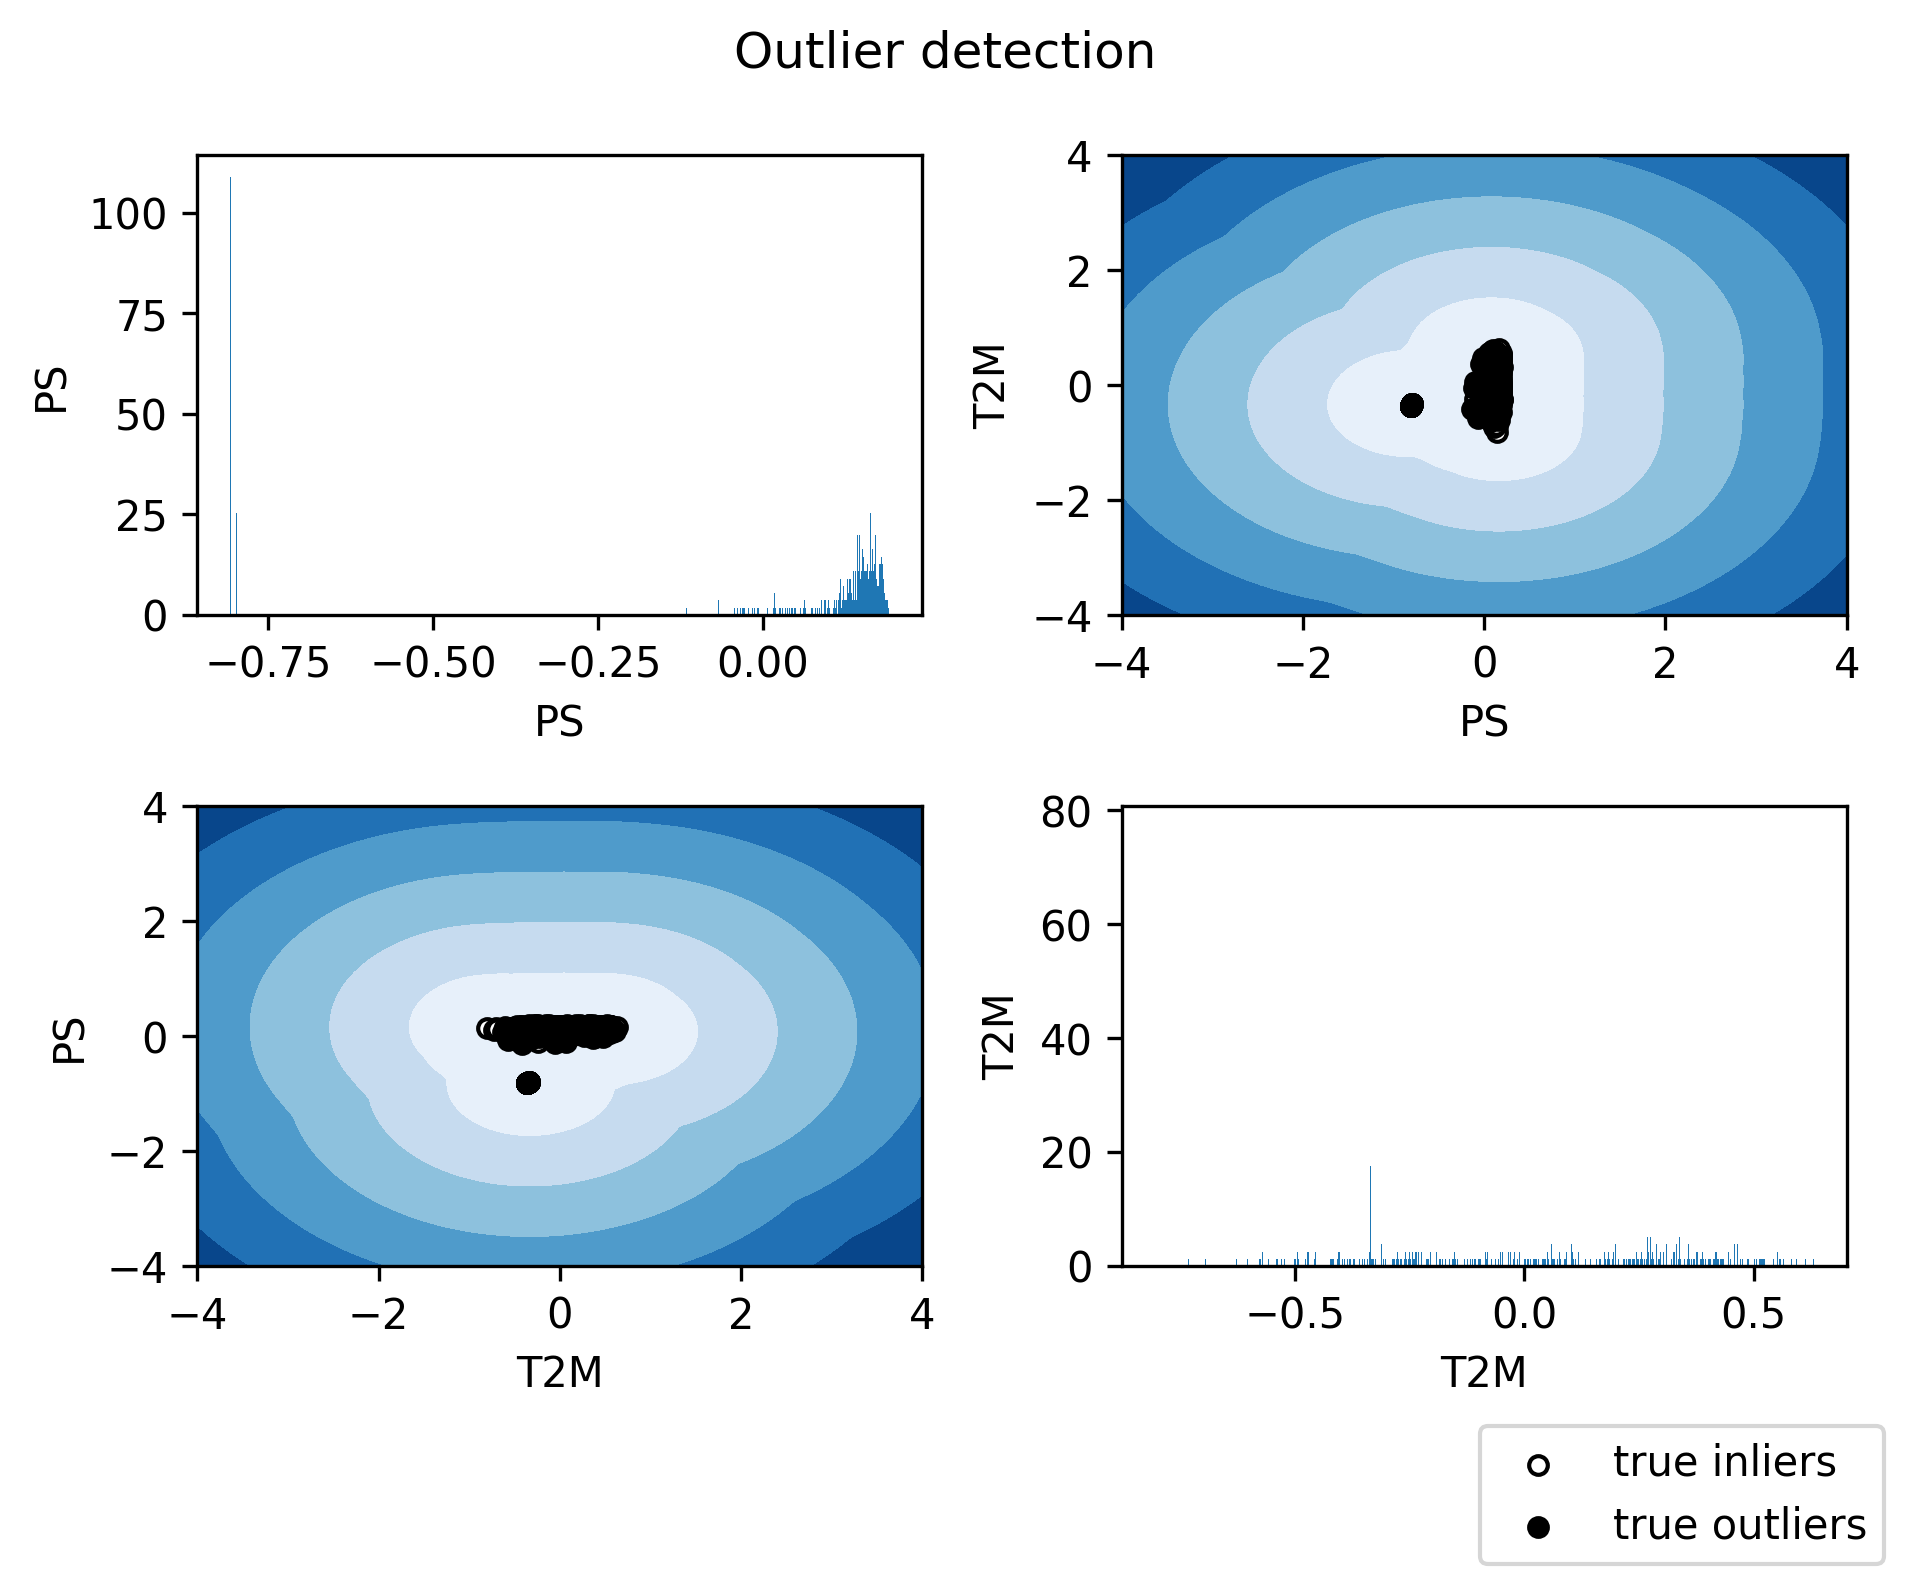

In [18]:
output_data= classifier.inference()

## Wrap-up: 


In this tutorial we have seen: 

- How to use your dataset with the toolbox
- How to choose your algorithm
- Required files to prepare before working with the toolbox
- How the algorithm is trained
- How the algorithm is evaluated



Reminder: To run your code you only need your database.py and the config.yaml files. After setting up them, you only need to execute the toolbox using the following instruction:

    python main.py --config=./configs/config.yaml

## References

Angiulli, F., and Pizzuti, C., 2002. Fast outlier detection in high dimensional
spaces. European Conference on Principles of Data Mining and Knowl-
edge Discovery, pp. 15–27, Springer.

Minixhofer, C., Swan, M., McMeekin, C., & Andreadis, P. (2021, July). DroughtED: A dataset
            and methodology for drought forecasting spanning multiple climate zones. In
            Tackling Climate Change with Machine Learning: Workshop at ICML 2021

Zhao, Y., Nasrullah, Z. and Li, Z., 2019. PyOD: A Python Toolbox for Scalable Outlier
            Detection. Journal of machine learning research (JMLR), 20(96), pp.1-7.